# Usable UMIs Amount Estimation
To avoid sequencing and PCR errors, we use only UMIs with multiple duplicate reads. To determine a required sequencing depth (number of reads per cell), we would like to model the relationship between sequencing depth and number of UMIs present in given number of duplicates.


In [1]:
import pysam
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from tqdm import tqdm
from collections import Counter
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
import pandas as pd

In [2]:
bam_files_data_folder = Path('/cellfile/datapublic/jkoubele/DR_dataset/AL4_old', desc='Processing .bam files')

@dataclass
class CellStatistics(DataClassJsonMixin):
    barcode: str
    num_reads: int
    duplicate_counter: dict[int, int]
        
@dataclass
class Dataset(DataClassJsonMixin):
    cells: list[CellStatistics]
    

run_processing_of_bam_files = False # change to True to re-run the .bam files processing
if run_processing_of_bam_files:
    cells: list[CellStatistics] = []
    for file_path in tqdm(bam_files_data_folder.iterdir()):
        if file_path.suffix != '.bam':
            continue
        samfile = pysam.AlignmentFile(file_path, "rb")
        reads = [read for read in samfile if read.mapq >= 255 and 
                 read.has_tag('UB') and
                 read.get_tag('UB') != '-' and
                 read.reference_name != 'chrM']
        umi_counter = Counter([read.get_tag('UB') for read in reads])
        cells.append(CellStatistics(barcode=file_path.stem,
                                   num_reads=len(reads),
                                    duplicate_counter = dict(Counter(umi_counter.values()))
                                   ))    

    with open(f'./duplicate_counters_{bam_files_data_folder.stem}.json', 'w') as file_out:
        file_out.write(Dataset(cells=cells).to_json())
    
        

In [3]:
with open('./duplicate_counters_AL4_old.json') as input_file:
    dataset = Dataset.from_json(input_file.read())
    cells = dataset.cells

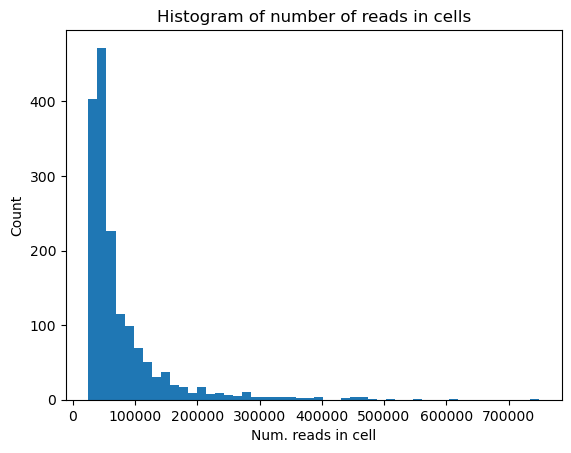

Descriptive statistics:
 count      1643.000000
mean      77017.091905
std       69638.623491
min       25043.000000
25%       39670.000000
50%       51759.000000
75%       84637.500000
max      749563.000000
dtype: float64


In [4]:
with open('./duplicate_counters_AL4_old.json') as input_file:
    dataset = Dataset.from_json(input_file.read())
    cells = dataset.cells

num_reads = [cell.num_reads for cell in cells]

plt.hist(num_reads, bins=50)
plt.xlabel('Num. reads in cell')
plt.ylabel('Count')
plt.title('Histogram of number of reads in cells')
plt.show()

print("Descriptive statistics:\n", pd.Series(num_reads).describe())

count    1643.000000
mean        0.108068
std         0.005731
min         0.095043
25%         0.104792
50%         0.107340
75%         0.110235
max         0.157184
dtype: float64

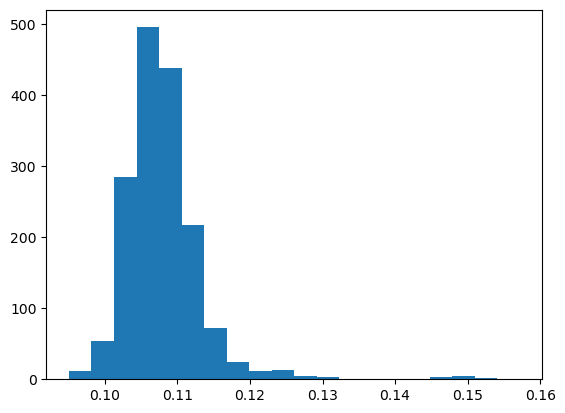

In [11]:
fraction_of_1_duplicates = [cell.duplicate_counter[2] / cell.num_reads for cell in cells]
plt.hist(fraction_of_1_duplicates, bins=20)
pd.Series(fraction_of_1_duplicates).describe()

<Axes: >

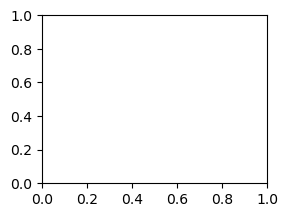

In [15]:
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(222, frameon=False)

# add a polar subplot
plt.subplot(223, projection='polar')

# add a red subplot that shares the x-axis with ax1
plt.subplot(224, sharex=ax1, facecolor='red')